The aim of this small Notebook is:
1. to load CSV files from https://lwillem.shinyapps.io/socrates_rshiny/ and paste them into separate sheets in an XLXS file.
2. to load data from `/raw/interaction_matrices/demographic/TF_SOC_POP_STRUCT_2020.xlsx` and create initial populations per region and per new age stratification

In [22]:
# Define various choices for age stratification.
age_lims_phases = [12, 18, 25, 35, 45, 55, 65, 75, 85]
age_lims_decades = [10,20,30,40,50,60,70,80]
age_lims=dict({'phases' : age_lims_phases,
               'decades': age_lims_decades})

age_names_phases = ['[0, 12)', '[12, 18)', '[18, 25)', '[25, 35)', '[35, 45)', '[45, 55)', '[55, 65)', '[65, 75)', '[75, 85)', '85+']
age_names_decades = ['[0, 10)', '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '[70, 80)', '80+']
age_names=dict({'phases' : age_names_phases,
                'decades': age_names_decades})

# Interaction matrices (same in every region)

Note: this code should be augmented for the CoMix data!

In [2]:
import pandas as pd

######### USER INPUT ###########
# Choose dataset
dataset = 'willem_2012'
# Choose age stratification: decades or life phases
stratification = 'phases'
######### USER INPUT ###########

# All possible subdirectories to loop over
# All XLSX files
locations = ['total', 'home', 'work', 'school', 'transport', 'leisure', 'otherplace']
# All sheets within XLSX files
contacts = ['all', 'physical_only', 'less_5_min', 'less_15_min', 'more_15_min', 'more_one_hour', 'more_four_hours']

# Define directory of raw data
interaction_raw = f'../../data/raw/interaction_matrices/{dataset}/CSVs/{stratification}'
# Define directory of interim data (target)
interaction_interim = f'../../data/interim/interaction_matrices/{dataset}/{stratification}'

In [78]:
# Define function to create the more_5_min DataFrame
def create_more_5_min(CSV_dir, dataset, stratification, loc):
    contact_df_all = pd.read_csv(f'{CSV_dir}/{loc}/{dataset}_{stratification}_{loc}_all.csv')
    contact_df_less_5_min = pd.read_csv(f'{CSV_dir}/{loc}/{dataset}_{stratification}_{loc}_less_5_min.csv')
    contact_df_more_5_min = contact_df_all - contact_df_less_5_min
    return contact_df_more_5_min

# Define function to give proper names to the DataFrame
def clean_df(raw_df, age_names):
    clean_df = raw_df.copy()
    clean_df['age_group']=age_names
    clean_df = clean_df.set_index('age_group')
    return clean_df

# Define function that collects the CSVs into an XLSX file and immediately saves it there
def create_XLSX(source_dir, target_dir, stratification, dataset, locations, contacts):
    for loc in locations:
        print(f"Working on social environment {loc}       ", end='\r')
        engine='openpyxl'
        with pd.ExcelWriter(f'{target_dir}/{loc}_{stratification}.xlsx', engine=engine) as XLSX:
            for con in contacts:
                # Create a sheet with name {con} inside the excel file XLSX
                contact_df = pd.read_csv(f'{source_dir}/{loc}/{dataset}_{stratification}_{loc}_{con}.csv')
                contact_df = clean_df(contact_df, age_names[stratification])
                contact_df.to_excel(XLSX, sheet_name=con)
                if con=='less_5_min':
                    # Create more_5_min sheet right after less_5_min
                    contact_df = create_more_5_min(source_dir, dataset, stratification, loc)
                    contact_df = clean_df(contact_df, age_names[stratification])
                    contact_df.to_excel(XLSX, sheet_name='more_5_min')
    print("Done.", " "*40)
    return

In [77]:
# Create the XLSX files. Uncomment to execute.

create_XLSX(interaction_raw, interaction_interim, stratification, dataset, locations, contacts)

Done.                                          


# Population per age per region

Note that this code is not optimised, but considering this code is only executed once or twice, that's not too bad.

In [61]:
import pandas as pd
import numpy as np

######### USER INPUT ###########
# Choose age stratification: decades or life phases
stratification = 'phases'
# Choose aggregation level: 'mun', 'arr', or 'prov'
agg = 'prov'
######### USER INPUT ###########

# define column name based on aggregation level
NIS_col = dict({'mun' : 'CD_REFNIS',
                'arr' : 'CD_DSTR_REFNIS',
                'prov' : 'CD_PROV_REFNIS'})

# Define directory of raw data
population_raw = f'../../data/raw/interaction_matrices/demographic/TF_SOC_POP_STRUCT_2020.xlsx'
# Define directory of interim data (target)
population_interim = f'../../data/interim/demographic/{stratification}'

# Load raw file -- takes a while
# raw_df = pd.read_excel(population_raw)
# raw_df.head()
# -----------------

In [62]:
def create_initN(age_names, stratification, agg):
    # Define column names and add 'total' column
    col_names = age_names[stratification] + ['total']

    # Load list of NIS values of user-defined aggregation level. Location hard-coded.
    NIS_list_df = pd.read_csv(f"../../data/interim/demographic/area_{agg}.csv")
    NIS_list = NIS_list_df['NIS'].sort_index().values

    # Initialise doubly stratified population matrix with correct dimensions
    initN = np.zeros([len(NIS_list), len(col_names)], dtype=int)

    # Iterate over NIS values (rows)
    for g in range(len(NIS_list)):
        nis = NIS_list[g]
        # Special case for provincial aggregation: add arrondissement Brussels as de facto 11th province
        if (agg=='prov') & (nis == 21000):
            # Hardcode column name 'CD_DSTR_REFNIS', because that is the place to look for if condition is met
            region = raw_df[raw_df['CD_DSTR_REFNIS']==nis]
            age_previous=0
            for i in range(len(age_lims[stratification])):
                age = age_lims[stratification][i]
                # Choose subset of all entries with particular age range
                region_age = region[(region['CD_AGE'] < age) & (region['CD_AGE'] >= age_previous)]
                # Sum population over all entries that obey the conditions
                pop = region_age['MS_POPULATION'].sum(axis=0)
                # Add this population to the initN matrix
                initN[g,i] = pop
                # Update age limits for next iteration
                age_previous = age
            # Add rest category (anything > final age limit) to penultimate column
            region_old = region[(region['CD_AGE'] >= age_lims[stratification][-1])]
            pop = region_old['MS_POPULATION'].sum(axis=0)
            initN[g,-2] = pop
            # Add total population over all ages to final column
            initN[g,-1] = initN[g,:-1].sum()
        # All other NIS values or spatial aggregations
        else:
            # Choose subset of all entries with particular NIS code
            region = raw_df[raw_df[NIS_col[agg]]==nis]
            # Iterate over all age limits according to the chosen stratification
            age_previous=0
            for i in range(len(age_lims[stratification])):
                age = age_lims[stratification][i]
                # Choose subset of all entries with particular age range
                region_age = region[(region['CD_AGE'] < age) & (region['CD_AGE'] >= age_previous)]
                # Sum population over all entries that obey the conditions
                pop = region_age['MS_POPULATION'].sum(axis=0)
                # Add this population to the initN matrix
                initN[g,i] = pop
                # Update age limits for next iteration
                age_previous = age
            # Add rest category (anything > final age limit) to penultimate column
            region_old = region[(region['CD_AGE'] >= age_lims[stratification][-1])]
            pop = region_old['MS_POPULATION'].sum(axis=0)
            initN[g,-2] = pop
            # Add total population over all ages to final column
            initN[g,-1] = initN[g,:-1].sum()

    initN_df = pd.DataFrame(initN, columns=col_names, index=NIS_list)
    initN_df.index.name = 'NIS'
    return initN_df

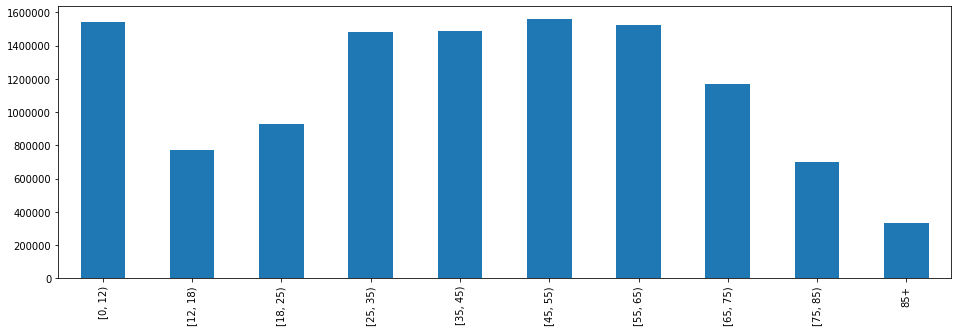

In [63]:
# Create, plot and save the resulting initial population
initN_df = create_initN(age_names, stratification, agg)

# Save to the proper location
initN_df.to_csv(f"{population_interim}/initN_{stratification}_{agg}.csv")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
initN_df_plot = initN_df.drop('total',axis='columns')
# Plot sum over all regions
initN_df_plot.sum(axis=0).plot(ax=ax, kind='bar')

# Model parameters (hospital parameters) per age class

## UZ Gent parameters

In [81]:
# Uncomment line below to create new dataset for model parameters from UZ Gent hospital data

# %run ./AZMM-UZG-data-analysis.py

## Hospitalisation and asymptomatic fraction per age
A.k.a. Davies data and Verity data.

### Verity et al.

*NOTE*: I am not sure what the `CFR` column in `verity_etal.csv` denotes.

These are resampled from the decades-based data. That is to say: this is a _temporary fix_! These we will use whilst awaiting better suited data from Sciensano (found in the raw data file `S:\fbw_covid19\data\raw\sciensano\Data_SurveillanceSciensano\Data_Hospitals\IndHospitalSurvey\COVID19BE_CLINIC.csv`

The rationale behind this _naïve_ resampling is as follows:

**Assumptions**:
- We assume (because there is no other quick way) that every age within every age group has equal representation within the age class. That is to say: if ages 0 to 9 represent 10 percent of the population, we say that the age of 0 represents 10/10 = 1 percent of the population.
- We assume (again, because there is no other quick way) that every subject within the age class, regardless of their age, has the same parameter values as the age class average.
- The maximum age is assumed to be 109 (so 80+ includes 30 ages)

**Mathematics**:
- Take two age classes, $A_0 = [a_0, a_1[$ and $A_1 = [a_1, a_2[$
- These age classes have age fractions $f_0$ and $f_1$, so fraction-per-year of $\phi_0 = \frac{f_0}{a_1-a_0}$ and $\phi_1=\frac{f_1}{a_2-a_1}$, resp.
- These age classes have a corresponding percentage parameter $\beta_0$ and $\beta_1$
- We define a new age class $A_0' = [a_0', a_1'[$ with $a_0' \in A_0$ and $a_1' \in A_1$.
- The corresponding percentage parameter $\beta_0'$ is calculated as follows, which always produces a value $\text{min}(\beta_0, \beta_1) < \beta_0' < \text{max}(\beta_0, \beta_1)$

$$\beta_0' = \beta_0 \frac{\phi_0(a_1 - a_0')}{\phi_0(a_1-a_0') + \phi_1(a_1'-a_1)} + \beta_1\frac{\phi_1(a_1' - a_1)}{\phi_0(a_1-a_0') + \phi_1(a_1'-a_1)}$$

In the case that $\beta_0 = \beta_1 = \beta$, this reduces to

$$\beta_0' = \frac{\beta\phi_0(a_1 - a_0') + \beta\phi_1(a_1' - a_1)}{\phi_0(a_1-a_0') + \phi_1(a_1'-a_1)} = \beta,$$

as it should. In the case where $A_0' = A_0$, i.e. where $a_0' = a_0$ and $a_1' = a_1$, this reduces to

$$\beta_0' = \beta_0 \frac{\phi_0(a_1 - a_0)}{\phi_0(a_1-a_0) + \phi_1(a_1-a_1)} + \beta_1\frac{\phi_1(a_1 - a_1)}{\phi_0(a_1-a_0) + \phi_1(a_1-a_1)} = \beta_0,$$

as it should. In the case where $A_0' = A_1$, i.e. where $a_0 = a_1$ and $a_1 = a_2$, this reduces to

$$\beta_0' = \beta_0 \frac{\phi_0(a_1 - a_1)}{\phi_0(a_1-a_1) + \phi_1(a_2-a_1)} + \beta_1\frac{\phi_1(a_2 - a_1)}{\phi_0(a_1-a_1) + \phi_1(a_2-a_1)} = \beta_1,$$

again, as it should. This is therefore a robust mathematical method that takes a population-weighted parameter value for a newly defined age class.

**Example**
- Age class $A_0 = [0, 10[$ has $\beta_0=$ `symptomatic_hospitalized` value 0.1 and fraction-per-year of $\phi_0 = 0.110424/10=0.0110424$
- Age class $A_1 = [10, 20[$ has $\beta_1=$ `symptomatic_hospitalized` value 0.3 and fraction-per-year of $\phi_1 = 0.113138/10=0.0113138$
- We define a new age class $[0, 12[$
- The calculated corresponding denominator is then

$$\phi_0(a_1-a_0') + \phi_1(a_1'-a_1) = 0.0110424 \times (10 - 0) + 0.0113138 \times (12-10) = 0.1330516$$

- The calculated `symptomatic_hospitalized` parameter is then

$$\beta_0' = 0.1 \times \frac{0.0110424 \times (10-0)}{0.1330516} + 0.3 \times \frac{0.0113138 \times (12-10)}{0.1330516} = 0.1340132$$

**Problem**

If both $a_0', a_1' \in A_0$, the corresponding parameter $\beta_0$ should take the same value as the value belonging to the age class $A_0$. This should be hard-coded in the algorithm. This is the case for life phase $[12, 18[$, which is completely withing $[10, 20[$, and life phase 85+, which is completely withing 80+.

In [20]:
import pandas as pd
import numpy as np

# Load 'decades' and only focus on making the 'phases' dataset
raw_dir = '../../data/raw/model_parameters'
verity_decades = pd.read_csv(f"{raw_dir}/verity_etal.csv")

# Add column with weights based on the total Belgian population
from covid19model.data import model_parameters
initN = model_parameters.get_interaction_matrices(stratification='decades', spatial=None)[0]
total_pop = initN.sum()
verity_decades['age_fraction'] = initN/total_pop

verity_decades

,age_group,symptomatic_hospitalized,hospitalized_ICU,CFR,age_fraction
0,0-9,0.1,5.0,0.003,0.110424
1,10-19,0.3,5.0,0.015,0.113138
2,20-29,1.2,5.0,0.060,0.122482
3,30-39,3.2,5.0,0.146,0.129847
4,40-49,4.9,6.3,0.295,0.130913
5,50-59,10.2,12.2,1.250,0.138404
6,60-69,16.6,27.4,3.990,0.117218
7,70-79,24.3,43.2,8.610,0.080425
8,80+,27.3,70.9,13.400,0.057148


In [65]:
# This needs to be tweaked if another age stratification that 'phases' is chosen

# Define empty array for parameter values for new age class
# N = len(age_lims['phases'])
# sympt_hosp_array = np.zeros(N+1)
# hosp_ICU_array = np.zeros(N+1)
# CFR_array = np.zeros(N+1)

sympt_hosp_array = np.array([])
hosp_ICU_array = np.array([])
CFR_array = np.array([])

previous_age_decades=0
previous_age_phases=0
idx=0
for age_phases in age_lims['phases']:
    # Define symptomatic_hospitalized, hospitalized_ICU, and CFR parameter value of corresponding decade
    sympt_hosp_lower = verity_decades.iloc[idx]['symptomatic_hospitalized']
    hosp_ICU_lower = verity_decades.iloc[idx]['hospitalized_ICU']
    CFR_lower = verity_decades.iloc[idx]['CFR']
    # Special case for non-overlapping age class
    if age_phases==18:
        sympt_hosp_array = np.append(sympt_hosp_array, sympt_hosp_lower)
        hosp_ICU_array = np.append(hosp_ICU_array, hosp_ICU_lower)
        CFR_array = np.append(CFR_array, CFR_lower)
        continue
    age_decades_middle = age_lims['decades'][idx]
    sympt_hosp_upper = verity_decades.iloc[idx+1]['symptomatic_hospitalized']
    hosp_ICU_upper = verity_decades.iloc[idx+1]['hospitalized_ICU']
    CFR_upper = verity_decades.iloc[idx+1]['CFR']
    # Define age fraction for overlapping classes
    age_fraction_lower = verity_decades.iloc[idx]['age_fraction']
    age_fraction_upper = verity_decades.iloc[idx+1]['age_fraction']
    # Define fraction-per-age for overlapping age classes
    fraction_per_age_lower = age_fraction_lower / (age_decades_middle - previous_age_decades)
    try:
        fraction_per_age_upper = age_fraction_upper / (age_lims['decades'][idx+1] - age_decades_middle)
    except:
        # limit case: upper bound is age 110
        fraction_per_age_upper = age_fraction_upper / (110 - age_decades_middle)
    # Define denominator (see mathematical formula above)
    denom = fraction_per_age_lower * (age_decades_middle - previous_age_phases) \
                                + fraction_per_age_upper * (age_phases - age_decades_middle)
    # Calculate new parameters
    sympt_hosp_phases = sympt_hosp_lower * fraction_per_age_lower * (age_decades_middle - previous_age_phases) / denom \
                                + sympt_hosp_upper * fraction_per_age_upper * (age_phases - age_decades_middle) / denom
    hosp_ICU_phases = hosp_ICU_lower * fraction_per_age_lower * (age_decades_middle - previous_age_phases) / denom \
                                + hosp_ICU_upper * fraction_per_age_upper * (age_phases - age_decades_middle) / denom
    CFR_phases = CFR_lower * fraction_per_age_lower * (age_decades_middle - previous_age_phases) / denom \
                                + CFR_upper * fraction_per_age_upper * (age_phases - age_decades_middle) / denom
    # Add values to arrays
    sympt_hosp_array = np.append(sympt_hosp_array, sympt_hosp_phases)
    hosp_ICU_array = np.append(hosp_ICU_array, hosp_ICU_phases)
    CFR_array = np.append(CFR_array, CFR_phases)
    # Update lower bound of age class
    previous_age_decades = age_decades_middle
    previous_age_phases = age_phases
    # Update idx value
    idx += 1
    
# Add final value for 85+, which is equal to the value for 80+
sympt_hosp_array = np.append(sympt_hosp_array, verity_decades.iloc[8]['symptomatic_hospitalized'])
hosp_ICU_array = np.append(hosp_ICU_array, verity_decades.iloc[8]['hospitalized_ICU'])
CFR_array = np.append(CFR_array, verity_decades.iloc[8]['CFR'])

array([ 0.13401316,  0.3       ,  0.6632058 ,  2.22918859,  4.05347422,
        7.62370712, 13.13477652, 19.73328639, 24.87450622, 27.3       ])

In [66]:
# Create new DataFrame with the new age stratification in the same conventions
age_group = np.array(['0-11', '12-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+'])
verity_phases = pd.DataFrame({'age_group' : age_group,
                              'symptomatic_hospitalized' : sympt_hosp_array,
                              'hospitalized_ICU' : hosp_ICU_array,
                              'CFR' : CFR_array})

verity_phases.to_csv()

,age_group,symptomatic_hospitalized,hospitalized_ICU,CFR
0,0-11,0.134013,5.000000,0.005041
1,12-17,0.300000,5.000000,0.015000
2,18-24,0.663206,5.000000,0.033160
3,25-34,2.229189,5.000000,0.104255
4,35-44,4.053474,5.652657,0.220805
5,45-54,7.623707,9.332051,0.785781
6,55-64,13.134777,19.170094,2.506451
7,65-74,19.733286,33.829341,5.869972
8,75-84,24.874506,48.504607,9.527295
9,85+,27.300000,70.900000,13.400000
